# Tarea INFO286: Minería de Procesos

Integrantes: Felipe Córdova y Javier Reyes  
Profesor: Juan Salazar  
Fecha: 09/05/2025  


## Resumen

En este trabajo se analiza el log de eventos `traffic_fines`, el cual representa el proceso de gestión de multas de tránsito en Italia. Se utilizaron herramientas del ecosistema `bupaR` en R para explorar el log, visualizar el proceso, responder preguntas específicas y proponer mejoras. Se identificaron cuellos de botella, variantes comunes y actividades críticas. Entre los principales hallazgos destacan demoras considerables en ciertas etapas y la existencia de múltiples variantes del proceso. Se proponen dos mejoras orientadas a reducir tiempos muertos y simplificar el flujo de actividades.


### Instalación y carga de paquetes

In [44]:
# Instalar los paquetes solo la primera vez:
# install.packages("bupaR")
# install.packages("eventdataR")  # contiene el log traffic_fines
# install.packages("edeaR")       # análisis exploratorio
# install.packages("processmapR") # mapas de proceso
# install.packages("processmonitR") # monitoreo
# install.packages("DiagrammeR")

# Cargar los paquetes:
library(bupaR)
library(eventdataR)
library(edeaR)
library(processmapR)
library(processmonitR)
library(ggplot2)
library(DiagrammeR)

### Cargar el log *traffic_fines*

In [45]:
data("traffic_fines")

## 1. Descripción general del log

En esta sección se realiza una revisión exploratoria de los datos del proceso, identificando aspectos clave como la cantidad de casos, el número de actividades distintas, las ventanas de tiempo involucradas, la duración de los casos, la cantidad y distribución de variantes, así como los participantes que intervienen en el proceso.

Dado que el log ya ha sido cargado, procedemos a presentar un resumen general de los datos.

In [46]:
# Resumen general del log
summary(traffic_fines)

Number of events:  34724
Number of cases:  10000
Number of traces:  44
Number of distinct activities:  11
Average trace length:  3.4724

Start eventlog:  2006-06-17
End eventlog:  2012-03-26



   case_id                                activity        lifecycle    
 Length:34724       Create Fine               :10000   complete:34724  
 Class :character   Send Fine                 : 6570                   
 Mode  :character   Payment                   : 4910                   
                    Add penalty               : 4635                   
                    Insert Fine Notification  : 4635                   
                    Send for Credit Collection: 3387                   
                    (Other)                   :  587                   
    resource       timestamp                         amount         
 559    : 1278   Min.   :2006-06-17 00:00:00.00   Length:34724      
 557    : 1181   1st Qu.:2007-07-19 00:00:00.00   Class :character  
 541    : 1119   Median :2007-10-29 00:00:00.00   Mode  :character  
 561    : 1002   Mean   :2007-12-06 15:34:51.32                     
 558    :  948   3rd Qu.:2008-02-29 00:00:00.00                     
 (Other): 

Algunos de los datos solicitados pueden observarse en el resumen general obtenido previamente mediante la función `summary(data)` en R. Sin embargo, a continuación se presentan algunos comandos específicos de la librería bupaR que permiten visualizar esta información de manera más clara y detallada.

### 1.1 Número de casos

In [47]:
n_cases(traffic_fines)

[1] 10000

### 1.2 Número de actividades distintas

In [48]:
n_activities(traffic_fines)

[1] 11

In [49]:
# Ver el nombre de las 11 actividades
activities(traffic_fines)

activity,absolute_frequency,relative_frequency
<fct>,<int>,<dbl>
Create Fine,10000,0.287985255
Send Fine,6570,0.189206313
Payment,4910,0.141400760
Add penalty,4635,0.133481166
Insert Fine Notification,4635,0.133481166
Send for Credit Collection,3387,0.097540606
Insert Date Appeal to Prefecture,232,0.006681258
Send Appeal to Prefecture,227,0.006537265
Receive Result Appeal from Prefecture,55,0.001583919


### 1.3 Descripción detallada de las actividades en `traffic_fines` (Según ChatGPT)

1. **Create Fine**  
   Registro inicial de la infracción en el sistema. Marca el inicio del expediente sancionador, incluyendo datos del vehículo, infracción y autoridad competente.

2. **Send Fine**  
   Envío de la multa al infractor, generalmente por correo certificado. Es el paso formal para informar al ciudadano sobre la infracción detectada.

3. **Insert Fine Notification**  
   Confirmación de la recepción formal de la notificación por parte del infractor. A partir de este punto comienzan a contar los plazos legales para pagar o apelar.

4. **Add Penalty**  
   Aplicación de un recargo económico debido al impago dentro del plazo establecido (normalmente 60 días). Se considera que el infractor ha incurrido en morosidad.

5. **Payment**  
   Registro de un pago, total o parcial, realizado por el infractor. Puede producirse en diferentes etapas del proceso, incluso después de penalizaciones.

6. **Send for Credit Collection**  
   Transferencia del expediente a una agencia de recobro (ej. *Agenzia delle Entrate-Riscossione*) si no se ha pagado tras un periodo prolongado (por ejemplo, 180 días).

7. **Insert Date Appeal to Prefecture**  
   Registro de la fecha en que el infractor manifiesta su intención de apelar la multa ante el Prefetto. Esta acción debe realizarse dentro de los 60 días posteriores a la notificación.

8. **Send Appeal to Prefecture**  
   Envío formal del recurso de apelación a la Prefectura, junto con documentación y argumentos del infractor.

9. **Receive Result Appeal from Prefecture**  
   Recepción del veredicto emitido por el Prefetto sobre la apelación (aceptación o rechazo de la misma).

10. **Notify Result Appeal to Offender**  
   Comunicación del resultado de la apelación al infractor. Si fue rechazada, el proceso continúa con el cobro de la multa.

11. **Appeal to Judge**  
   Presentación de una apelación ante el *Giudice di Pace* (juez de paz), como vía judicial alternativa o posterior a la Prefectura.

### 1.4 Ventana de tiempo que abarca

In [50]:
# Ventana de tiempo que abarca
start_time <- min(traffic_fines$timestamp)
end_time <- max(traffic_fines$timestamp)
start_time
end_time

[1] "2006-06-17 UTC"

[1] "2012-03-26 UTC"

El log abarca un período de casi seis años, comprendido entre el 17 de junio de 2006 y el 26 de marzo de 2012.

### 1.5 Duración de los casos (tiempo total de ejecución de los casos)

In [51]:
throughput_time(traffic_fines, units="days")

min,q1,median,mean,q3,max,st_dev,iqr
<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<dbl>,<drtn>
0 days,7 days,125 days,296.1351 days,596 days,1956 days,313.2794,589 days


### 1.6 Distribución de variantes al 80% de los casos

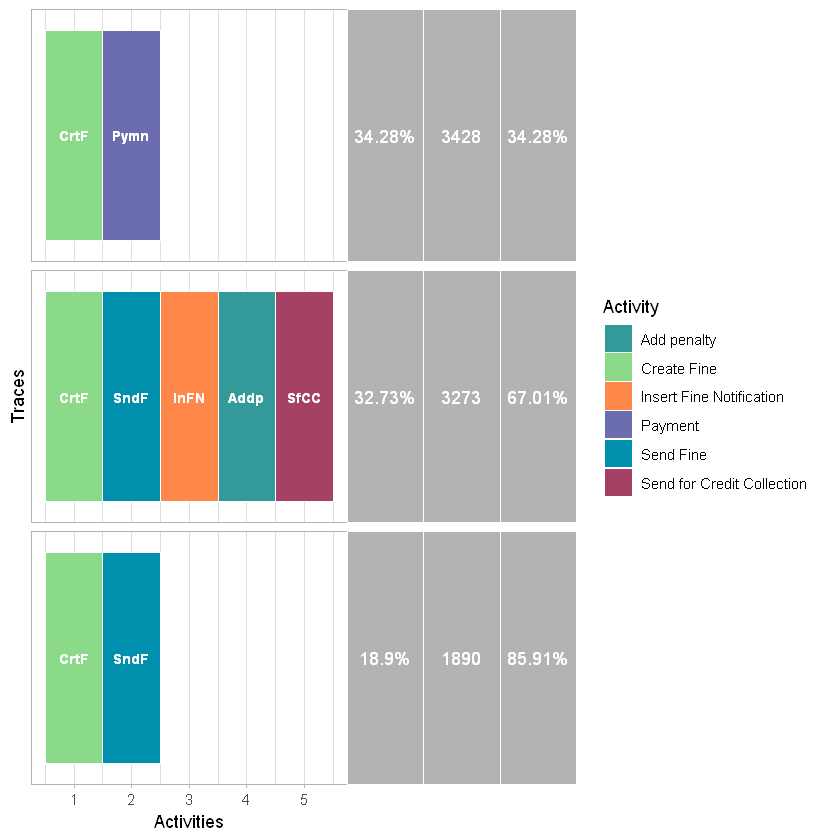

In [52]:
trace_explorer(traffic_fines, coverage = 0.8)

### 1.7 Personas que participan en el proceso

In [53]:
resource_frequency(traffic_fines, level = "resource") %>%
  mutate(percentage = absolute / sum(absolute) * 100)


resource,absolute,relative,percentage
<fct>,<int>,<dbl>,<dbl>
NA,24705,0.7114675729,71.14675729
559,1278,0.0368045156,3.68045156
557,1181,0.0340110586,3.40110586
541,1119,0.0322255501,3.22255501
561,1002,0.0288561226,2.88561226
558,948,0.0273010022,2.73010022
537,946,0.0272434051,2.72434051
564,602,0.0173367124,1.73367124
556,600,0.0172791153,1.72791153


Antes de completar nuestra tabla con una descripción general del log, revisamos los nombres de todas las columnas para identificar la información disponible y poder deducir cual información de utilidad podría faltar.

In [54]:
# Columnas en el log
colnames(traffic_fines)

[1] "case_id"              "activity"             "lifecycle"           
 [4] "resource"             "timestamp"            "amount"              
 [7] "article"              "dismissal"            "expense"             
[10] "lastsent"             "matricola"            "notificationtype"    
[13] "paymentamount"        "points"               "totalpaymentamount"  
[16] "vehicleclass"         "activity_instance_id" ".order"

### 1.8 Descripción General 

| Información | Cantidad | 
| :--| :-- |
| Número de casos |  10000 casos |
| Número de actividades únicas | 11 actividades |
| Ventana de tiempo | [2006-06-17, 2012-03-26] |
| Duración de los casos | En promedio 296.1351 días |
| Cantidad de variantes | 44 variantes (traces) |
| Distribución de variantes | A pesar de que el log contiene 44 variantes distintas, solo 3 de ellas concentran más del 85% de los casos. La variante más frecuente representa por sí sola el 34.28% de los casos, seguida de dos variantes con 32.73% y 18.9%, respectivamente. Esto indica que, aunque hay una diversidad considerable de secuencias, la mayoría de los casos sigue un conjunto muy limitado de rutas de proceso. |
| Personas / Roles que participan | Se identifican los siguientes id: 561 / 537 / 550 / 541 / 557 / 558 / 559 / 0 / 536 / 560 / 562 / 563 / 564 / 556 / 538. Pero, 24705 eventos o actividades no tienen una persona específicamente asignada (persona no registrada NA) | 
| Con qué información se cuenta | Los procesos empiezan con **Create Fine** y terminan con: **Payment**, **Send for Credit Collection** y **Send Fine**. Pueden ser finalizados por diferentes roles según el resultado: **Payment** implica resolución por parte del ciudadano, mientras que **Send for Credit Collection** y **Send Fine** corresponden a acciones administrativas posteriores por parte de la autoridad. |
| Con qué información no se cuenta | Faltan datos sobre la ubicación de la infracción, que permitirían análisis geográficos del proceso. También se echa de menos información del conductor y del tipo específico de infracción. Además, no se incluye el estado final del caso, lo que dificultaría evaluar su resolución completa. |

## 2. Análisis de diagrama del proceso

En esta sección se analiza el diagrama del proceso con el fin de comprender el comportamiento general del flujo de trabajo. Se identifican las variantes más frecuentes, los puntos del proceso donde se concentran las principales demoras, y se determinan aquellas variantes que inician con la actividad `Create Fine` y concluyen correctamente con la actividad `Payment`, lo que indica un cierre exitoso del caso. Este análisis permite detectar patrones, cuellos de botella y evaluar la eficiencia del proceso.

### 2.1 Diagrama de procesos

Para crear el diagrama de procesos, debido a algunos inconvenientes técnicos, no fue posible visualizar el diagrama utilizando únicamente el comando `process_map()`. Aunque la ejecución era correcta, el resultado no se mostraba en la consola de Jupyter Notebook. Por lo tanto, se utilizó la librería `DiagrammeR` (cargada al inicio) junto con un widget HTML para poder visualizar el diagrama en el navegador. Una vez hecho esto, se procedió a tomar una captura de pantalla y guardar el diagrama bajo el nombre `diagrama_proceso.png` en la carpeta **imagenes**. Además, se creó un archivo `.gitignore` para evitar que se suban las carpetas generadas durante la creación del gráfico y del archivo HTML. Se deja comentado el código utilizado para evidencia.

In [55]:
# Diagrama de procesos clásico
# graph <- process_map(traffic_fines)

# Guardar como HTML
# htmlwidgets::saveWidget(graph, "proceso_traffic_fines.html")

A continuación se presenta la imagen.  

<img src="imagenes/diagrama_proceso.png" alt="Diagrama del proceso"/>


Como se puede observar en la imagen, así como en el gráfico presentado en la Sección 1 sobre la distribución de variantes que abarcan el 80% del total de casos, las principales variantes del proceso corresponden a aquellas que presentan un color más intenso y flechas de mayor grosor. Tal como se explicó en clases, esto indica una mayor frecuencia de ocurrencia. A medida que disminuye la intensidad del color, también lo hace la frecuencia relativa de la variante.  

### 2.2 Variantes principales

Entre las variantes más representativas del proceso, se identifican las siguientes secuencias:

1. **Start** → `Create Fine` → `Payment` → **END**  
2. **Start** → `Create Fine` → `Send Fine` → `Insert Fine Notification` → `Add penalty` → `Send for Credit Collection` → **END**  
3. **Start** → `Create Fine` → `Send Fine` → **END**  

Vistas en la sección 1.6 al 80% y continuación de ejecuta el mismo comando al 90% para poder rescatar otra variante "poco" frecuente pero igual importante.  

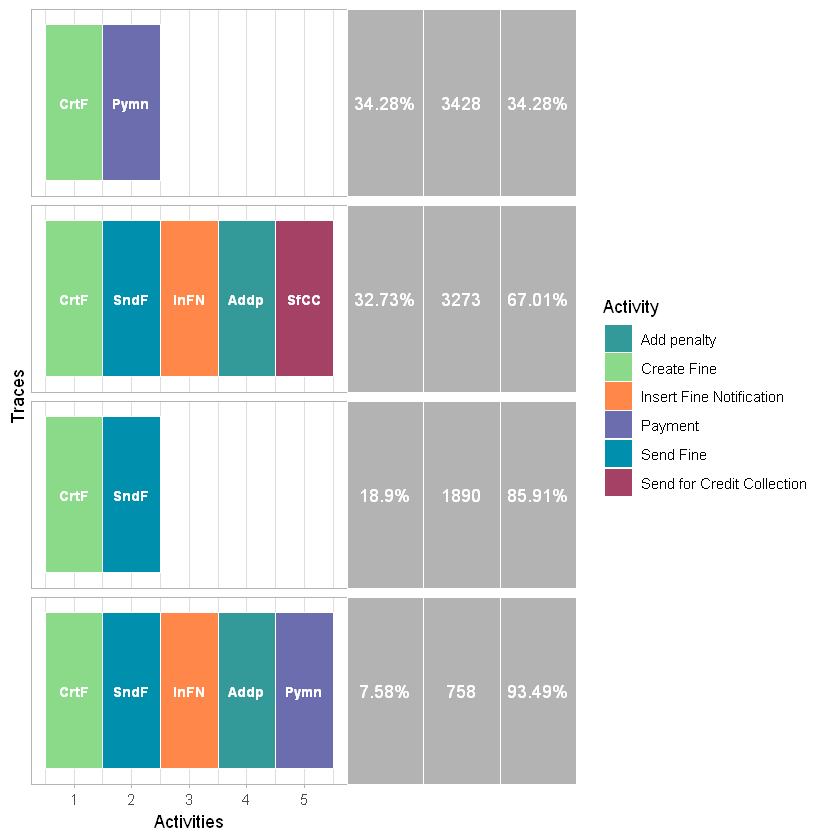

In [56]:
trace_explorer(traffic_fines, coverage = 0.9)

A partir de la imagen, se identifica una cuarta variante relevante, que representa el 7,58 % del total de los casos, y que también debe ser considerada en el análisis debido a su frecuencia significativa.  

4. **Start** → `Create Fine` → `Send Fine` → `Insert Fine Notification` → `Add penalty` → `Payment` → **END**  

Este gráfico, presentado anteriormente en la sección 1.6 y retomado aquí (al 90%), facilita la comprensión del diagrama de procesos. Al mostrar las variantes más frecuentes de manera simplificada, ayuda a interpretar un proceso que, debido a la gran cantidad de líneas y caminos posibles, puede resultar complejo de entender visualmente.

### 2.3 Frecuencias

se presenta este diagrama se complementa adecuadamente con el análisis realizado mediante el comando `activities(traffic_fines)`, presentado en la Sección 1, donde se identifican las once actividades que conforman el proceso. En dicho análisis también se observa la frecuencia absoluta de cada actividad, lo que permite comprender en mayor profundidad la estructura y dinámica del flujo de eventos.

| Actividad | Frecuencia | 
| :--| :-- |
| Create Fine |  10000 |
| Send Fine | 6570 |
| Payment | 4910 |
| Add penalty | 4635 |
| Insert Fine Notification | 4635 |
| Send for Credict Collection | 3387 |
| Insert Date Appeal to Prefecture | 232 |
| Send Appeal to Prefecture | 227 |
| Receive Result Appeal from Prefecture | 55 |
| Notify Result Appeal to Offender | 54 |
| Appeal to Judge | 19 |

### 2.4 Principales demoras

Al igual que anteriormente, para visualizar el diagrama de demoras se utilizó DiagrammeR junto con visualización en HTML, debido a las limitaciones de Jupyter Notebook. La imagen fue capturada y guardada en la carpeta de **imagenes** como `diagrama_demoras.png`, y se deja el código utilizado como evidencia.

In [57]:
# Mapa con tiempo promedio entre actividades en dias
# graph <- process_map(traffic_fines, performance(median, "days"))

# Guardar como HTML
# htmlwidgets::saveWidget(graph, "proceso_traffic_fines_times.html")

A continuación se presenta la imagen mencionada. En estas transiciones, destacadas en color amarillo, representan los mayores tiempos de espera entre actividades.

<img src="imagenes/diagrama_demoras.png" alt="Diagrama de demoras">

Como se observa en la imagen, se identifican cinco demoras principales en el proceso, las cuales se resumen en el gráfico de barras elaborado en R, a continuación:

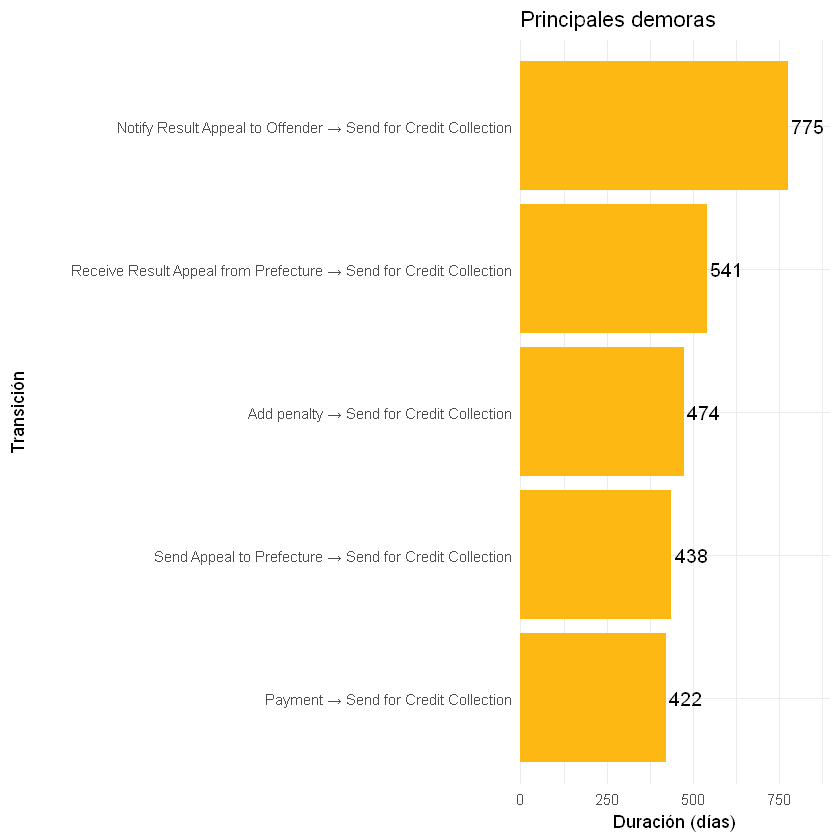

In [58]:
# Crear un data frame con las demoras
demoras <- data.frame(
  transicion = c(
    "Notify Result Appeal to Offender → Send for Credit Collection",
    "Receive Result Appeal from Prefecture → Send for Credit Collection",
    "Add penalty → Send for Credit Collection",
    "Send Appeal to Prefecture → Send for Credit Collection",
    "Payment → Send for Credit Collection"
  ),
  dias = c(775, 541, 474, 438, 422)
)

# Graficar con etiquetas y espacio adicional
ggplot(demoras, aes(x = reorder(transicion, dias), y = dias)) +
  geom_bar(stat = "identity", fill = "#FDB813") +
  geom_text(aes(label = dias), hjust = -0.1, size = 4) +  # Etiquetas fuera de la barra
  coord_flip() +
  labs(title = "Principales demoras",
       x = "Transición",
       y = "Duración (días)") +
  theme_minimal() +
  scale_y_continuous(expand = expansion(mult = c(0, 0.16)))  # espacio extra a la derecha


Estas demoras podrían reflejar ineficiencias en la comunicación y seguimiento entre etapas. La mayor demora es de 775 días (aproximadamente 2 años y 1 mes), lo cual representa un tiempo excesivo. Optimizar estas áreas podría reducir significativamente la duración total del proceso.

### 2.5 Variantes que inician y terminan correctamente

Debemos entender mejor el proceso para poder determinar cuales variantes son las que inician y terminan correctamente, 

Consultando a ChatGPT, un proceso correcto contempla:

#### Proceso resumido de multas de tránsito en Italia

1. **Notificación**  
   - Si el conductor es detenido, la multa se entrega en el acto.  
   - Si no, se envía por correo certificado al propietario del vehículo (plazo máximo: 90 días desde la identificación).

2. **Pago**  
   - **Descuento del 30%** si se paga dentro de los primeros **5 días**.  
   - Pago completo posible hasta **60 días**.  
   - Pasado ese plazo, se aplican recargos y el caso pasa a la agencia de recaudación estatal.

3. **Recurso**  
   - Se puede apelar ante el **Prefetto** (60 días) o el **Giudice di Pace** (30 días).

4. **Cobro forzoso**  
   - Si no se paga ni se apela, se procede al cobro mediante embargo u otras medidas coercitivas.




Entonces,podemos decir que las variantes que terminan correctamente son aquellas que:
1. Finalizan con el pago de la multa (_Payment_)
2. El Infractor apela y la apelación es aceptada (_Notify Result Appeal to Offender_)
3. El cobro esta atrasado y se recurre a una agencia de cobros(_Send for Credit Collection_)

## 3. Análisis del log mediante preguntas

En esta sección se analiza el log de eventos respondiendo preguntas clave que permiten explorar el proceso desde distintas perspectivas. Se aplican distintas herramientas vistas en clases para comprender mejor su funcionamiento y detectar posibles mejoras.

### 3.1 ¿Cuáles son los caminos más frecuentes que se siguen en este proceso / subproceso? 

Esta pregunta resulta algo redundante, ya que en las secciones 1.6 y 2.2 se identificaron los caminos más frecuentes del proceso (al 80% y 90%, respectivamente). En la sección 1.6 se observó que el 85.91 % de los casos sigue principalmente tres variantes, siendo las más comunes aquellas que comienzan con `Create Fine` y concluyen en `Payment` , `Send for Credit Collection` y `Send Fine`.

### 3.2 Identifique algún punto de decisión del proceso y descríbalo. ¿Cuáles son los caminos de salida de esa actividad? ¿Qué camino es más o menos frecuente? 

In [59]:
# Analizar las salidas desde "Add penalty"
precedence_matrix(traffic_fines, type = "absolute") %>%
  filter(antecedent == "Add penalty") %>%
  arrange(desc(n)) -> decision_point

print(decision_point)

# A tibble: 6 × 3
  antecedent  consequent                                n
  <fct>       <fct>                                 <int>
1 Add penalty Send for Credit Collection             3288
2 Add penalty Payment                                1117
3 Add penalty Send Appeal to Prefecture               171
4 Add penalty Insert Date Appeal to Prefecture         41
5 Add penalty Receive Result Appeal from Prefecture    15
6 Add penalty Notify Result Appeal to Offender          3


Un punto de decisión importante en el proceso (viendo el diagrama de la sección 2.1) es la actividad `Add penalty`. Esta actividad presenta múltiples caminos de salida, lo cual indica que en este punto se toman decisiones que determinan distintas rutas para el caso.

Desde `Add penalty`, los caminos de salida son (viendo la ayuda de código previamente):  
- `Send for Credit Collection`: 3288 veces  
- `Payment`: 1177  
- `Send Appeal to Prefecture`: 171 veces  
- `Insert Date Appeal to Prefecture`: 41 veces  
- `Receive Result Appeal from Prefecture`: 15 veces  
- `Notify Result Appeal to Offender`: 3 veces  


El camino más frecuente es hacia **Send for Credit Collection**, con 3288 casos, lo que representa la gran mayoría de los flujos salientes desde esta actividad.

En contraste, los caminos menos frecuentes son aquellos relacionados con apelaciones, como **Notify Result Appeal to Offender** (3 veces) y **Receive Result Appeal from Prefecture** (15 veces), lo que indica que son pocos los casos en que los infractores deciden apelar la multa.

In [60]:
# Analizar las salidas desde "Send Fine"
precedence_matrix(traffic_fines, type = "absolute") %>%
  filter(antecedent == "Send Fine") %>%
  arrange(desc(n)) -> decision_point

print(decision_point)

# A tibble: 4 × 3
  antecedent consequent                           n
  <fct>      <fct>                            <int>
1 Send Fine  Insert Fine Notification          4633
2 Send Fine  End                               1893
3 Send Fine  Payment                             42
4 Send Fine  Insert Date Appeal to Prefecture     2


Aunque la actividad **Send Fine** presenta un mayor número de ocurrencias (6570 veces), se caracteriza por tener un flujo más lineal y predecible, principalmente derivando a **Insert Fine Notification** (4653 veces) o a **End** (1893 veces). En cambio, la actividad **Add penalty** actúa como un verdadero punto de decisión dentro del proceso, ya que desde ahí se ramifican múltiples caminos con distintos propósitos. Esta diversidad de salidas convierte a **Add penalty** en una actividad crítica para comprender las distintas trayectorias del proceso, no solo por su volumen (4635 ocurrencias), sino por su impacto estructural en el flujo posterior.

In [61]:
# Analizar las salidas desde "Insert Fine Notification"
precedence_matrix(traffic_fines, type = "absolute") %>%
  filter(antecedent == "Insert Fine Notification") %>%
  arrange(desc(n)) -> decision_point

print(decision_point)

# A tibble: 4 × 3
  antecedent               consequent                           n
  <fct>                    <fct>                            <int>
1 Insert Fine Notification Add penalty                       4417
2 Insert Fine Notification Insert Date Appeal to Prefecture   188
3 Insert Fine Notification Payment                             16
4 Insert Fine Notification Appeal to Judge                     14


Como mencionamos en el parrafo anterior, ocurre la misma idea para Insert Fine Notification.

### 3.3 ¿Dónde se producen cuellos de botella? ¿Ocurren estos en actividades muy frecuentes, o poco frecuentes?

### 3.4 ¿Existen algunos trabajadores que tarden más o menos tiempo en realizar el trabajo? 

Sí, se puede inferir que existen diferencias entre los trabajadores en cuanto al tiempo que tardan en realizar su trabajo, aunque la tabla presentada en la sección 1.7 no muestra directamente tiempos de procesamiento, sino la frecuencia con que cada recurso participa en el proceso.

Por ejemplo, el recurso identificado como 559 participó en 1278 eventos (3,68%), mientras que 536 solo participó en 20 casos (0,057%). Otros recursos como 557, 541 o 561 también muestran una "poca" participación, lo que podría sugerir que son más eficientes, están más disponibles o se les asignan tareas de menor duración. En cambio, los recursos con baja frecuencia podrían estar asignados a actividades menos frecuentes, más complejas o que requieren más tiempo para completarse.

Además, un 71,1% de los eventos no tienen recurso asignado (NA), lo que sugiere que gran parte del proceso podría ser automático o no estar trazado por persona, lo cual limita el análisis completo del desempeño individual.

En resumen, aunque no contamos con datos de duración por trabajador (por temas de código), la variabilidad en la cantidad de casos asignados a cada recurso permite suponer que sí existen diferencias en el tiempo o eficiencia con que cada trabajador realiza sus tareas.

En esta sección, utilizamos diferentes técnicas y gráficos vistos en las secciones 1 y 2. Estos gráficos fueron clave para responder a las preguntas planteadas, permitiendo analizar el proceso desde diversas perspectivas. Aunque no se pudieron responder más preguntas interesantes debido a problemas técnicos con la instalación de librerías, el enfoque permitió obtener información valiosa sobre el proceso.

## 4. Propuesta de mejoras al proceso

A partir del análisis realizado en las secciones anteriores, se han identificado áreas del proceso que podrían beneficiarse de mejoras para optimizar su eficiencia y reducir tiempos o errores. Las siguientes propuestas buscan simplificar el flujo de trabajo, reducir reprocesos y mejorar la eficacia general del proceso de gestión de multas de tránsito, basándose en los hallazgos obtenidos del log de eventos.

### 4.1 Optimización de la comunicación entre etapas clave del proceso (notificación y envío para cobro)

Las demoras más significativas (observando el diagrama de la sección 2.4) ocurren en la transición entre etapas críticas, como de **Notify Result Appeal to Offender** a **Send for Credit Collection** (775 días), o de **Add penalty** a **Send for Credit Collection** (474 días). Estas demoras podrían deberse a procesos manuales o a falta de automatización en la comunicación entre las diferentes etapas.

### Propuesta:

* Automatización del flujo de información: Implementar un sistema automatizado que notifique a las partes involucradas (incluso con recordatorios) de manera rápida sobre los siguientes pasos una vez que se ha tomado una decisión en la apelación o se ha agregado la penalización. Esto podría incluir el uso de herramientas de gestión de procesos o integración de sistemas que comuniquen automáticamente la información a las partes correspondientes, reduciendo así la necesidad de pasos manuales y los posibles retrasos en la comunicación.

* Definir alertas y tiempos de respuesta automáticos: Para cada paso crítico, establecer alertas automáticas cuando los procesos estén por vencer o necesiten intervención para evitar que se queden sin seguimiento.


### 4.2 Revisión y mejora del proceso de apelación y pago

Las transiciones entre **Receive Result Appeal from Prefecture** y **Send for Credit Collection** (541 días), y de **Payment** a **Send for Credit Collection** (422 días) indican que hay retrasos significativos en el manejo de las apelaciones y pagos, lo cual podría estar relacionado con la lentitud en la validación de la información, aprobación o procesamiento de pagos.

### Propuesta:

* Simplificación y digitalización del proceso de apelaciones y pagos: Mejorar la eficiencia de la revisión de apelaciones y la validación de pagos mediante el uso de plataformas digitales o aplicaciones móviles que permitan a los usuarios cargar directamente los documentos requeridos o realizar pagos de manera inmediata. Esto reduciría el tiempo dedicado a la espera de respuesta, y aceleraría la transición hacia el cobro por parte de la entidad de crédito.

* Revisión de los tiempos de espera: Evaluar los criterios de aprobación y tiempos de espera asociados con las apelaciones y pagos. Si hay aprobaciones innecesarias o plazos excesivos, estos podrían ser reducidos, o bien automatizados, para acelerar el proceso.


### 4.3 Simplificación del proceso de apelación

El proceso de apelación incluye múltiples etapas (como registrar la intención de apelar, enviar la apelación, recibir el resultado, notificarlo, y eventualmente apelar a un juez), lo que lo hace extenso y propenso a demoras.

### Prpuesta:

* Consolidar algunas de estas etapas, por ejemplo, unificando el registro y envío de la apelación en una sola acción digital, y automatizando la notificación del resultado al infractor. Esto permitiría reducir tiempos, evitar reprocesos y simplificar el flujo general del proceso.

## Conclusión

En este trabajo se logró analizar el log de `traffic_fines`, identificando las principales etapas del proceso, las demoras y los cuellos de botella. A través de este análisis, se detectaron áreas clave que podrían beneficiarse de mejoras, como la simplificación del proceso de apelación y la reducción de tiempos de espera. Sin embargo, no fue posible responder a algunas preguntas planteadas debido a problemas técnicos con algunas librerías y fallos en Jupyter Notebook, lo que limitó un poco el alcance del análisis. A pesar de estas dificultades, el trabajo permitió obtener una visión más clara del proceso y sentar las bases para futuras mejoras en la eficiencia del mismo.


## Referencias
* https://link.springer.com/article/10.1007/s00607-015-0441-1
* https://chat.openai.com/
* https://github.com/rahulbhat44/Process-Mining-using-Prom-Lite